In [54]:
import os
import h5py
import scipy
import timeit
import pyfftw
import numpy as np 
import matplotlib.pyplot as plt  
import matplotlib.ticker as mticker


from scipy.fft import fftfreq, fftn, ifftn
from matplotlib import animation
from scipy.special import k0, k1
from tqdm.notebook import tqdm
from scipy.interpolate import RegularGridInterpolator
from matplotlib.animation import FuncAnimation 
from matplotlib.animation import PillowWriter
from matplotlib.animation import FFMpegWriter

plt.rcParams['text.usetex'] = True

In [55]:
class ULDM_Simulator():
    def __init__(self, dist='Iso_Gaussian', L=5, N=64, eps=1e-5):
        '''
        dist(str)       : distribution type
        L   (scalar)    : Length of the box
        N   (scalar)    : Number of grid points in each dimension
        eps (scalar)    : 4 pi G m^2 rho / sigma_k^4; related to Jeans wavelength
        '''
        self.eps = eps  

        self.set_grid(L, N)
        self.set_steps()
    
        self.f = self.set_distribution(dist)    
        self.set_initial_wavefunction()
    
    def set_grid(self, L, N):
        '''
        L (scalar): Length of the box
        N (scalar): Number of grid points in each dimension
        '''

        self.N = N 
        self.L = L
        self.dx = L/N

        # Set up the spatial grid
        self.X, self.Y, self.Z = np.meshgrid(
            np.linspace(-L/2, L/2, N),
            np.linspace(-L/2, L/2, N),
            np.linspace(-L/2, L/2, N),
            indexing='ij'
        )

        # Set up the Fourier grid
        self.KX, self.KY, self.KZ = np.meshgrid(
            fftfreq(self.N, self.dx) * 2 * np.pi, 
            fftfreq(self.N, self.dx) * 2 * np.pi, 
            fftfreq(self.N, self.dx) * 2 * np.pi,
            indexing='ij'
        )

        # 1 / k^2
        self.K2 = self.KX**2 + self.KY**2 + self.KZ**2
        self.invK2 = np.divide(1, self.K2, out=np.zeros((self.N, self.N, self.N)), where=(self.K2 !=0))
    
    def set_steps(self):
        self.T = self.L**2 / np.pi
        self.nt = self.N**2
        self.dt = self.T / self.nt

        self.time = np.arange(0, self.T, self.dt)

    def set_distribution(self, dist='Iso_Gaussian'):
        '''
        dist (str): Distribution type
        '''
        if dist == 'Iso_Gaussian':
            return lambda k: (2*np.pi)**1.5*np.exp(-k**2/2)
        
    def set_initial_wavefunction(self):
        self.farr = self.f(np.sqrt(self.KX**2 + self.KY**2 + self.KZ**2))

        PSI = np.random.rayleigh(1)
        PSI *= 1 / self.L**1.5
        PSI *= np.exp(1j * 2 * np.pi * np.random.rand(self.N, self.N, self.N))
        PSI *= np.sqrt(self.farr / 2)
        
        self.psi = ifftn(PSI, norm='forward')                       
        self.rhob = self.N**(-3) * np.sum(np.abs(self.psi)**2)    # average density

        self.Phi_fourier = fftn( self.eps * (np.abs(self.psi)**2 - self.rhob) ) * self.invK2
        self.Phi = np.real(ifftn(self.Phi_fourier))

    def evolve(self):
        '''
        Evolve field according to kick-drift-kick scheme
        '''
        self.psi *= np.exp(-0.5j * self.Phi * self.dt)  # kick
        self.psi = fftn(self.psi)
        self.psi *= np.exp(-0.5j * self.K2 * self.dt)   # drift
        self.psi = ifftn(self.psi)

        self.rhob = self.N**(-3) * np.sum(np.abs(self.psi)**2)

        self.Phi_fourier = fftn( self.eps * (np.abs(self.psi)**2 - self.rhob) ) * self.invK2
        self.Phi = np.real(ifftn(self.Phi_fourier))

        self.psi *= np.exp(-0.5j * self.Phi * self.dt)  # kick
    
    def solve(self, save_rho=True):
        if save_rho == True:
            self.rho = []
            for i in tqdm(self.time):
                self.rho.append((np.abs(self.psi)**2)[0,0,0])
                self.evolve()

In [56]:
sim = ULDM_Simulator()
sim.solve()

  0%|          | 0/4096 [00:00<?, ?it/s]

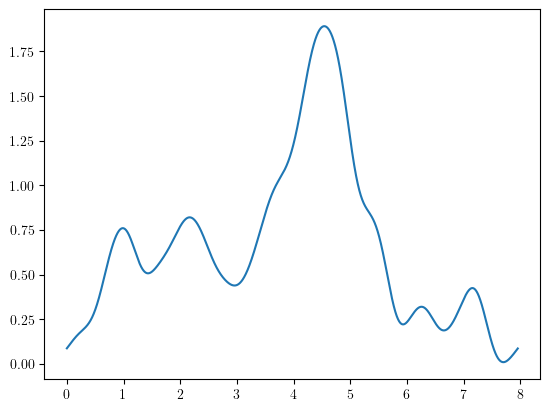

In [67]:
plt.plot(sim.time, sim.rho)

In [66]:
sim.time

array([0.00000000e+00, 1.94280936e-03, 3.88561873e-03, ...,
       7.95191873e+00, 7.95386154e+00, 7.95580435e+00])

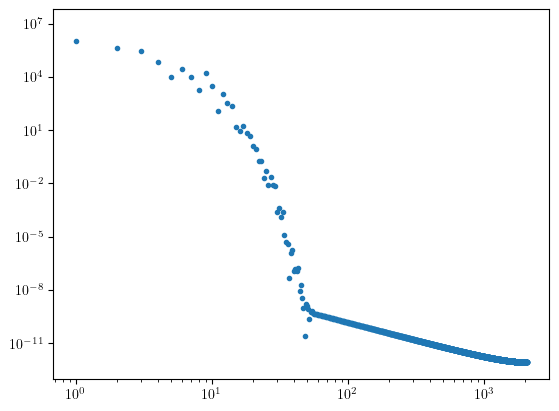

In [65]:
plt.plot((np.abs(fftn(sim.rho))**2)[:len(sim.rho)//2],'.')
plt.xscale('log')
plt.yscale('log')